In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.figure()
    if title is not None:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)

In [3]:
epochs = 3

# UTKFace Data

In [4]:
batch_size = 128

In [5]:
from data import UTKFace
dataset = UTKFace(transform=transforms.Compose([
                    transforms.Grayscale(),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()]),
                  label='gender'
                 )

Distribution is about 50-50 between male and female

In [6]:
idcs = np.arange(len(dataset))
np.random.seed(0) # This is important to split the same way every single time
np.random.shuffle(idcs)
split_idx = int(0.9 * len(dataset))
train_idcs = idcs[:split_idx]
test_idcs = idcs[split_idx:]

In [7]:
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)

### Toggle cell below for sample debugging

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
a_face, gender = dataset[1]
gender = dataset.classes[torch.argmax(gender,dim=0).item()]

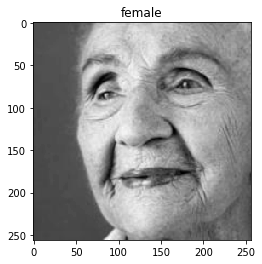

In [10]:
show(a_face, gender)

# Classifier Model

In [11]:
from models import Classifier

In [12]:
device = torch.device("cuda")

In [13]:
model = Classifier(2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [14]:
import torch.nn.functional as F

def train(epoch):
    model.train()
    train_loss = 0
    total_corr = 0
    for data, genders in tqdm(train_loader):
        genders = genders.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
        
        gender_idcs = torch.argmax(genders, dim=1)
        pred_idcs = torch.argmax(pred, dim=1)

        num_corr = torch.eq(gender_idcs, pred_idcs).sum()
        total_corr += num_corr
        
        loss = F.binary_cross_entropy(pred, genders)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    acc = total_corr.float() / len(train_loader.dataset)
    print('====> Epoch: {} acc: {:.4f} avg loss: {:.4f}'.format(
          epoch, acc, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    total_corr = 0
    with torch.no_grad():
        for data, genders in tqdm(test_loader):  
            genders = genders.to(device)
            data = data.to(device)
            pred = model(data)
            
            gender_idcs = torch.argmax(genders, dim=1)
            pred_idcs = torch.argmax(pred, dim=1)
            
            num_corr = torch.eq(gender_idcs, pred_idcs).sum()
            total_corr += num_corr
            
            test_loss += F.binary_cross_entropy(pred, genders).item()

    test_loss /= len(test_loader.dataset)
    acc = total_corr.float() / len(test_loader.dataset)
    print('====> Test acc: {:.4f}, loss: {:.4f}'.format(acc, test_loss))

# Load

In [15]:
weight_path = 'weights/{}_{}.pt'.format(model.__class__.__name__, dataset.__class__.__name__)
weight_path

'weights/Classifier_UTKFace.pt'

In [16]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))    

# Train

In [17]:
%%time
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

  0%|          | 0/19 [00:00<?, ?it/s]

====> Epoch: 1 acc: 0.5939 avg loss: 0.0052


  0%|          | 0/167 [00:00<?, ?it/s]

====> Test acc: 0.6639, loss: 0.0051


  0%|          | 0/19 [00:00<?, ?it/s]

====> Epoch: 2 acc: 0.6803 avg loss: 0.0048


  0%|          | 0/167 [00:00<?, ?it/s]

====> Test acc: 0.7010, loss: 0.0048


  0%|          | 0/19 [00:00<?, ?it/s]

====> Epoch: 3 acc: 0.7143 avg loss: 0.0046


100%|██████████| 19/19 [00:02<00:00,  7.18it/s]

====> Test acc: 0.7250, loss: 0.0045
CPU times: user 1min 33s, sys: 45.5 s, total: 2min 18s
Wall time: 2min 20s


# Save

In [18]:
torch.save(model.state_dict(), weight_path)

# Try it

In [19]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))    

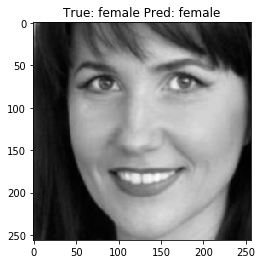

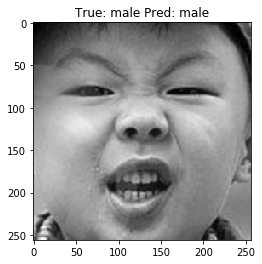

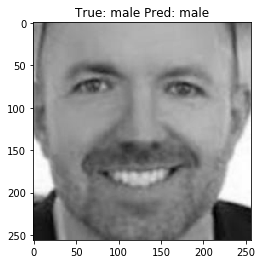

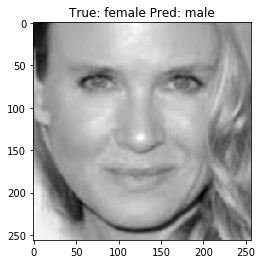

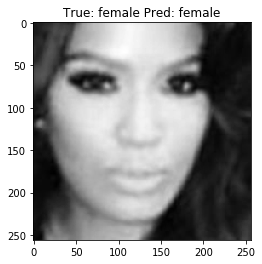

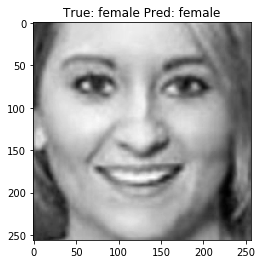

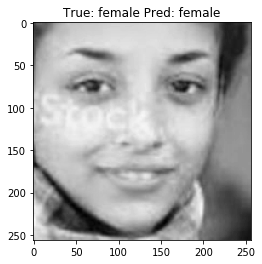

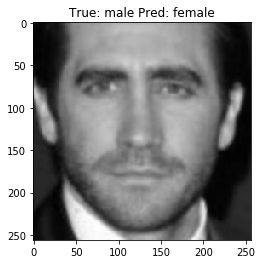

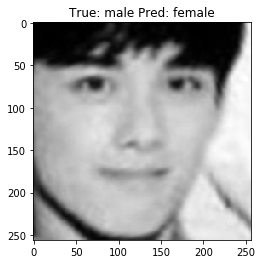

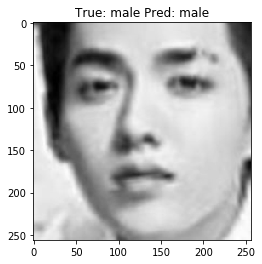

In [20]:
model.eval()

for idx in torch.utils.data.RandomSampler(test_dataset, num_samples=10, replacement=True):
    a_face, gender = test_dataset[idx]
    
    a_face = a_face.to(device)
    a_face = a_face.unsqueeze(0)
    
    pred = model(a_face)
    
    pred_idx = torch.argmax(pred, dim=1)
    gender_idx = torch.argmax(gender, dim=0)
    
    pred_class = dataset.classes[pred_idx]
    gender_class = dataset.classes[gender_idx]
    
    
    show(a_face.cpu().view(1,256,256), 'True: {} Pred: {}'.format(gender_class, pred_class))